In [1]:
# Import data
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
df = pd.read_excel('../data/barnstable_analysis_data.xlsx', sheet_name='data')
df = df.set_index('date')
df['Excess Returns'] = df['SPX'] - df['TB1M']
df.head()

returns = df['Excess Returns'].dropna()
returns.head()

# Calculate Expanding Historic VaR
# Need to use shift to say if we're at 2010, don't use 2010
historic_var = returns.shift().expanding(60).quantile(0.05)
df['Historic VaR'] = historic_var


<AxesSubplot: xlabel='date'>

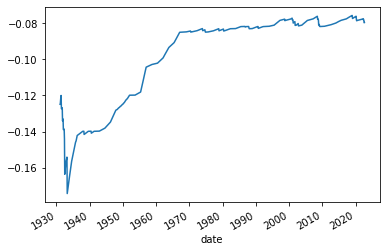

In [2]:
# 1(a) plot the historic 5th quantile VaR
historic_var.plot(kind='line')

In [3]:
# 1(b) Calculate the frequency of periods in which excess returns < historic 5th quantile VaR
df['Returns < VaR'] = df['Excess Returns'] < df['Historic VaR']
frequency = df[df['Returns < VaR'] == True].count()/df[61:].count()
percentage = sum(df['Excess Returns'] < df['Historic VaR'])/len(df['Historic VaR'].dropna())
print(f"The Excess Returns are less than the Historic VaR {round(percentage*100, 3)}% of the time")
print(f"The Excess Returns are less than the Historic VaR {round(frequency['Returns < VaR']*100, 3)}% of the time")

The Excess Returns are less than the Historic VaR 3.033% of the time
The Excess Returns are less than the Historic VaR 3.003% of the time


1(c) What drawbacks do you see in this Historic Var?
<br/><br/>
For one, since the time frame on this data is so large, as we approach the end of the time window, our VaR stabilizes to a common value, and makes it difficult test how our current portfolio is doing against relatively recent market moves. 

<AxesSubplot: xlabel='date'>

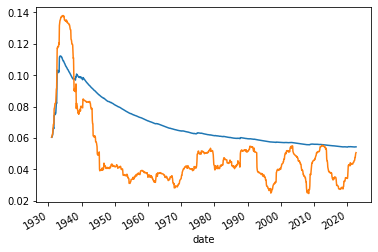

In [4]:
# 2(a) Volatility (Expanding Series)
sigma_expanding = returns.expanding(60).std()
sigma_expanding.plot()

# 2(a) Volatility (Rolling Series)
sigma_rolling = returns.rolling(60).std()
sigma_rolling.plot()

<AxesSubplot: xlabel='date'>

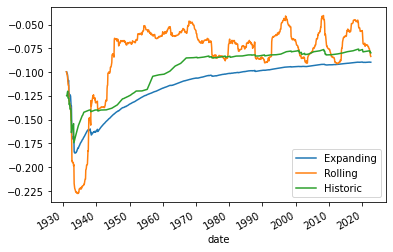

In [5]:
# 2(b) 1 Month Ahead VaR (Expanding Series)
expanding_VaR = -1.65*sigma_expanding
expanding_VaR.plot(legend=True, label="Expanding")

# 2(b) 1 Month Ahead VaR (Rolling Series)
rolling_VaR = -1.65*sigma_rolling
rolling_VaR.plot(legend=True, label="Rolling")

historic_var.plot(legend=True, label="Historic")

In [6]:
# 2(c) Frequency of returns < VaR (Expanding Series)
returnsAndVaR = pd.DataFrame(data = returns)
returnsAndVaR['Expanding VaR'] = expanding_VaR
returnsAndVaR['Less Than Expanding VaR'] = returnsAndVaR['Excess Returns'] < returnsAndVaR['Expanding VaR']
expandingVaRFreq = len(returnsAndVaR[returnsAndVaR['Less Than Expanding VaR'] == True])/len(returnsAndVaR['Expanding VaR'].dropna())
returnsAndVaR.tail()
print(f"The Excess Returns are less than the 1 Month Ahead Expanding VaR {round(expandingVaRFreq*100, 3)}% of the time")

# 2(c) Frequency of returns < VaR (Rolling Series)
# returnsAndVaR = pd.DataFrame(data = returns)
returnsAndVaR['Rolling VaR'] = rolling_VaR
returnsAndVaR['Less Than Rolling VaR'] = returnsAndVaR['Excess Returns'] < returnsAndVaR['Rolling VaR']
rollingVaRFreq = len(returnsAndVaR[returnsAndVaR['Less Than Rolling VaR'] == True])/len(returnsAndVaR['Rolling VaR'].dropna())
returnsAndVaR.tail()
print(f"The Excess Returns are less than the 1 Month Ahead Rolling VaR {round(rollingVaRFreq*100, 3)}% of the time")

# And Remember 
print(f"The Excess Returns are less than the Historic Expanding VaR {round(frequency['Returns < VaR']*100, 3)}% of the time")

The Excess Returns are less than the 1 Month Ahead Expanding VaR 1.745% of the time
The Excess Returns are less than the 1 Month Ahead Rolling VaR 5.234% of the time
The Excess Returns are less than the Historic Expanding VaR 3.003% of the time


2(d) Compare and contrast results
<br/><br/>
Based on the numbers given, we can see that the 1 Month Ahead Rolling VaR provides the best estimate of actual VaR, given that the excess returns are less than the VaR almost 5% of the time (which is what we were looking for with 5th quantile VaR). We can also see that the Expanding 1 month Lookahead VaR and Historic VaR match fairly closely, unlike the Rolling VaR which shows much more variance.

The CVaR for the empirical CDF is -0.127
The CVaR for the expanding volatility is -0.162
The CVaR for the rolling volatility is -0.104


<AxesSubplot: xlabel='date'>

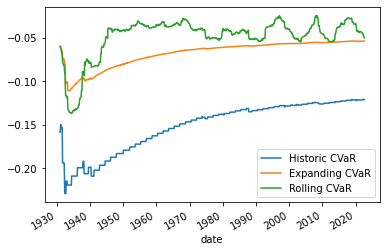

In [15]:
# 3(a) Calculate CVaR for empirical CDF, expanding volatility, and rolling volatility
z_q = -1.65 
q = 0.05
coef_CVaR = -stats.norm().cdf(z_q)/q

historic_cvar = (df[df['Excess Returns'] < df['Historic VaR']]).mean()
df['Historic CVaR'] = df['Excess Returns'].expanding(60).apply(lambda x:x[x<x.quantile(0.05)].mean())
print(f"The CVaR for the empirical CDF is {round(historic_cvar['SPX'],3)}")

expanding_cvar = (returnsAndVaR[returnsAndVaR['Less Than Expanding VaR'] == True]).mean()
print(f"The CVaR for the expanding volatility is {round(expanding_cvar['Excess Returns'],3)}")
df['Expanding CVaR'] = sigma_expanding*coef_CVaR

rolling_cvar = (returnsAndVaR[returnsAndVaR['Less Than Rolling VaR'] == True]).mean()
print(f"The CVaR for the rolling volatility is {round(rolling_cvar['Excess Returns'],3)}")
df['Rolling CVaR'] = sigma_rolling*coef_CVaR

df[['Historic CVaR', 'Expanding CVaR', 'Rolling CVaR']].plot()



## Section 3 Estimating Underperformance
1. Summary Statistics

In [8]:
# Estimating Underperformance
# 1. Summary Statistics
df2 = df[['SPX', 'TB1M', 'Excess Returns']].copy()

# 1 + is for cumulative returns
log_df = np.log(1 + df2)

def annualized_stats(data, annual_factor, log = False):
    if log == False:
        df = pd.DataFrame(data = None, 
                          index = ['rM','rtM','rf'])
    else: 
        df = pd.DataFrame(data = None, 
                      index = ['log rM','log rtM','log rf'])
        
    df[str(data.index[0].year) + '-' + str(data.index[-1].year) + ' mu'] = [data['SPX'].mean(),
                                                                                data['SPX'].mean()-data['TB1M'].mean(),
                                                                                data['TB1M'].mean()] 
    
    df[str(data.index[0].year) + '-' + str(data.index[-1].year) + ' mu'] *= annual_factor
    
    df[str(data.index[0].year) + '-' + str(data.index[-1].year) + ' sigma'] = [data['SPX'].std(),
                                                                                   (data['SPX']-data['TB1M']).std(),
                                                                                   data['TB1M'].std()] 
    
    df[str(data.index[0].year) + '-' + str(data.index[-1].year) + ' sigma'] *= np.sqrt(annual_factor)
    
    return df

def join(df_list):
    df = df_list[0]
    
    for df_ in df_list[1:]:
        df = df.join(df_)
    
    return df

stats_ = join([annualized_stats(df2.loc['1965':'1999'], 12),
             annualized_stats(df2.loc['2000':], 12),
             annualized_stats(df2.loc['1926':], 12)])

log_stats = join([annualized_stats(log_df.loc['1965':'1999'], 12, log = True),
                 annualized_stats(log_df.loc['2000':], 12, log = True),
                 annualized_stats(log_df.loc['1926':], 12, log = True)])

stats_df = stats_.append(log_stats)
stats_df

C:\Users\madrs\AppData\Local\Temp\ipykernel_24336\2632812281.py:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  stats_df = stats_.append(log_stats)


,1965-1999 mu,1965-1999 sigma,2000-2022 mu,2000-2022 sigma,1926-2022 mu,1926-2022 sigma
rM,0.129354,0.149405,0.075922,0.152555,0.113480,0.187378
rtM,0.067851,0.150227,0.061608,0.153097,0.081942,0.188102
rf,0.061503,0.007179,0.014314,0.004978,0.031538,0.008573
log rM,0.117600,0.149568,0.064032,0.153660,0.095657,0.186657
log rtM,0.056279,0.150397,0.049739,0.154185,0.064197,0.187318
log rf,0.061320,0.007132,0.014293,0.004968,0.031460,0.008539


1(b) Comment on how the full-sample return stats compare to sub-sample stats.
 - The full sample returns seem to fall in the middle of the two other subsamples, which makes sense considering it spans them both. The earlier returns are also generally higher than the later ones.
 - The level returns are also generally higher than the corresponding log returns.

In [9]:
# 2 Calculate probability that cumulative market return < cumulative risk free return
# Note: rf = risk free return, rtM = excess market return
# prob_calc returns the probability that the mean falls below the sigma for the given time frame using a cdf
# calculates probability of underperformance compared to the benchmark (risk-free rate in Barnes example)
# c from the equations is what we're comparing against, so for risk free rate c = 0, and for if we can exceed 6%, use c = 0.06
def prob_calc(h, tilde_mu, tilde_sigma):
    return stats.norm.cdf((- np.sqrt(h) * tilde_mu) / tilde_sigma)

def prob(h, tilde_mu, tilde_sigma):
    prob_df = pd.DataFrame(data = h, columns = ['h'])
    
    prob_df['Probability'] = prob_calc(prob_df['h'], tilde_mu, tilde_sigma)
    
    prob_df = prob_df.set_index('h')
    
    return prob_df

mu_tilde = stats_df.iloc[4, 0] # log rtM mu (return) Excess Returns mu
sigma_tilde = stats_df.iloc[4, 1] # log rtM sigma (volatility) Excess Returns sigma
h = 1999 - 1965

prob([h], mu_tilde, sigma_tilde)

,Probability
h,
34,0.014556


In [10]:
# 2(b) Report the probability for h = 15 and h = 30 years
prob([15, 30], mu_tilde, sigma_tilde)

,Probability
h,
15,0.073628
30,0.020201


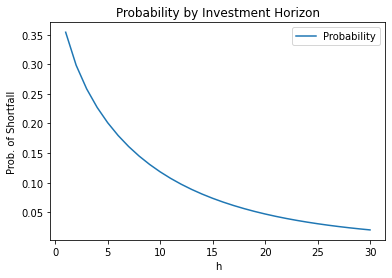

In [11]:
# 2(c) Plot the probability as a function of the investment horizon
prob_horizon = prob(list(range(1,31)), mu_tilde, sigma_tilde)

prob_horizon.plot() 
plt.title('Probability by Investment Horizon')
plt.ylabel('Prob. of Shortfall')
plt.show()

In [12]:
# 3 Use the 1965-2022 Sample to reconsider the 30 year probability
log_df1965 = log_df.loc['1965':].dropna()
mu_tilde = (log_df1965['SPX'].mean()-log_df1965['TB1M'].mean()) * 12
sigma_tilde = (log_df1965['SPX']-log_df1965['TB1M']).std() * np.sqrt(12)

prob(list(range(5,35, 5)), mu_tilde, sigma_tilde)

,Probability
h,
5,0.212393
10,0.129502
15,0.083420
20,0.055212
25,0.037155
30,0.025289


In [13]:
# 4(a) What was the probability that the 23 year market return was 
#       smaller than the realized return in 2000-2022?
mu = stats_df.iloc[3,0] # 1965-1999 market return mu
bar_r = stats_df.iloc[3,2] # 2000-2022 market return mu
sigma = stats_df.iloc[3,1] # 1965-1999 market return vol

prob([23], mu - bar_r, sigma)

,Probability
h,
23,0.042932


In [14]:
# 4(b) 
strike = np.log(1.06)
mu65 = log_df1965['SPX'].mean() * 12
sigma65 = log_df1965['SPX'].std() * np.sqrt(12)
# TODO: where did this equation come from?
# log market returns 2000-2022
mu = 23/7 * (stats_df.iloc[3, 2] - strike) + mu65 - strike

prob([7], mu, sigma65)

,Probability
h,
7,0.15674
